In [1]:
#this cell has what you will need to import

import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as optimise

#I use these to loop over the directories
import os
from pathlib import Path

from astropy.io import fits #to read a fits file

#I use this package to convert from redshift to year
#Renyue implied doing this conversion is trivial
#but it is not. I suggest reading up on this
#package and then using it.
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.272)

In [2]:
def read_sun(director):
    
    
    masses=[] 
    sfrs=[]
    metals=[]
    ages=[]
    
    for filename in os.listdir(director):
        
        if filename.startswith('sun'):
            
            sfile=director+'/'+filename
                    
            hdul = fits.open(sfile)
            data=hdul[4].data                
            hdul.close()
                    
            #here I calculate the star formation rate as the total
            #mass of star particles less than a Myr old
            good_age=data['age']<1e6
            sfr = sum(data['mass'][good_age])/1e6
            
            masses.append(np.array(data['mass']))
            sfrs.append(sfr)
            metals.append(np.array(data['metallicity']))
            ages.append(np.array(data['age']))
                    

    masses=np.array(masses)
    sfrs=np.array(sfrs)
    metals=np.array(metals)
    ages=np.array(ages)
    

    return masses,sfrs,metals,ages

In [3]:
mass,sfr,metals,ages=read_sun('out01461')

In [4]:
#Now info for the regular starburst99 file
hdul = fits.open('sb99kroupa4.fits')
data = hdul[1].data[0]

In [5]:
#Now info for the stripped starburst99 files
file14 = np.loadtxt('SED_Z0.014_starburst.txt')
minor14= np.delete(file14, 0, 0)
sed14 = np.delete(minor14,0,1)

file06 = np.loadtxt('SED_Z0.006_starburst.txt')
minor06= np.delete(file06, 0, 0)
sed06 = np.delete(minor06,0,1)

file02 = np.loadtxt('SED_Z0.002_starburst.txt')
minor02= np.delete(file02, 0, 0)
sed02 = np.delete(minor02,0,1)

file002 = np.loadtxt('SED_Z0.0002_starburst.txt')
minor002= np.delete(file002, 0, 0)
sed002 = np.delete(minor002,0,1)

wavelist = file14[0,1:]
agelist = minor14[:,0] #Wavelist and agelist are actually the reverse of what the txt files suggest
metlist = [0.0002, 0.002, 0.006, 0.014]


sedlist = np.asarray([sed002,sed02,sed06,sed14])
np.place(sedlist, sedlist==0, [1e-30])
sedlist = np.log10(sedlist)
#sedlist = np.swapaxes(sedlist,1,2)

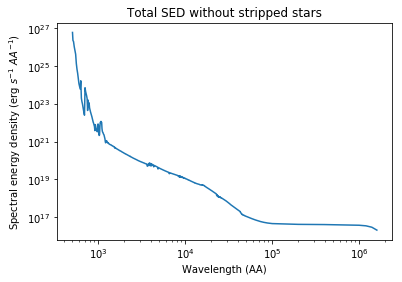

In [6]:
unstripped20 = np.loadtxt('regularout.txt')
unstripped30 = np.loadtxt('regularout30.txt')
unstripped40 = np.loadtxt('regularout40.txt')

plt.plot(data['wave'], unstripped20)
plt.title("Total SED without stripped stars")
plt.xlabel("Wavelength (AA)")
plt.ylabel("Spectral energy density (erg $s^{-1}$ $AA^{-1}$)")
plt.xscale('log')
plt.yscale('log')

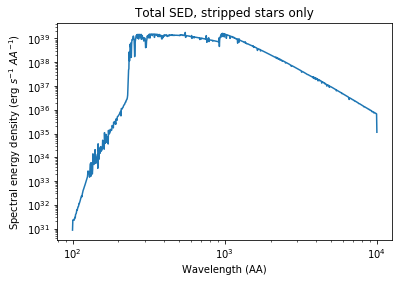

In [7]:
file14 = np.loadtxt('SED_Z0.014_starburst.txt')
stripwaves = file14[0,1:]
stripped = np.loadtxt('strippedout.txt')

plt.plot(stripwaves, stripped)
plt.title("Total SED, stripped stars only")
plt.xlabel("Wavelength (AA)")
plt.ylabel("Spectral energy density (erg $s^{-1}$ $AA^{-1}$)")
plt.xscale('log')
plt.yscale('log')

In [54]:
flatages = np.hstack(ages)
flatmasses = np.hstack(mass)
firststars = [gal[0] for gal in ages]
#firsthstars = [gal[0:1000] for gal in ages]
#print(firststars)
#print(ages)
#print(firsthstars)
print(len(ages[0]))

18677


Text(0.5, 0, 'Star particle age (years)')

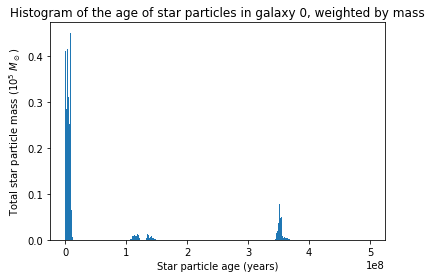

In [53]:
#plt.hist(flatages, bins=100, weights=flatmasses/1e7) #histogram of all star particles' ages
#plt.title("Histogram of the age of star particles, weighted by mass")
#plt.ylabel("Total star particle mass ($10^7\ M_\odot$)")
#plt.xlabel("Star particle age (years)")
plt.hist(ages[0], bins=np.arange(500)*1e6, weights=mass[0]/1e5) #histogram of all star particles' ages
plt.title("Histogram of the age of star particles in galaxy 0, weighted by mass")
plt.ylabel("Total star particle mass ($10^5\ M_\odot$)")
plt.xlabel("Star particle age (years)")

In [11]:
def funcsum(x1, y1, x2, y2): #takes 2 functions defined on different arrays and adds them together
    #y2 is stacked on top of the array x1
    len1 = len(x1)
    len2 = len(x2)
    toty = np.copy(y1)
    for i in range(len1):
        if (x1[i] > x2[0]) and (x1[i] < x2[len2-1]):
            toty[i] += y2[np.searchsorted(x2,x1[i])]
    return x1, toty

#sumwaves, sumsed = funcsum(data['wave'], unstripped20, stripwaves, stripped)
#plt.plot(sumwaves, sumsed)
#plt.title("Total SED with stripped stars")
#plt.xlabel("Wavelength")
#plt.ylabel("Spectral energy density")
#plt.xscale('log')
#plt.yscale('log')


In [12]:
def powerlaw(xdata, ydata):# Define function for calculating a power law

    ##########
    # Generate data points with zero error
    ##########
    # Note: all positive, non-zero data
    yerr = 0
    ##########
    # Logarithmic data fitting — least squares — from scipy-cookbook
    ##########

    # Power-law fitting is best done by first converting
    # to a linear equation and then fitting to a straight line.
    # Note that the `logyerr` term here is ignoring a constant prefactor.
    #
    #  y = a * x^b
    #  log(y) = log(a) + b*log(x)
    #

    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata
    n = len(logx)

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x))

    pinit = [37, -0.5]
    #out = optimise.leastsq(errfunc, pinit,
                           #args=(logx, logy, logyerr), full_output=1)

    #pfinal = out[0]
    #covar = out[1]
    #print pfinal
    #print covar

    #index = pfinal[1]
    #amp = 10.0**pfinal[0]
    
    index = (n*np.sum(np.multiply(logx, logy))-np.sum(logx)*np.sum(logy))/(n*np.sum(np.square(logx))-np.sum(logx)**2)

    #indexErr = np.sqrt( covar[1][1] )
    #ampErr = np.sqrt( covar[0][0] ) * amp

    return index


In [27]:
#We want to consider two slopes: one from 1200-2000A, one from 600-1000A
def datacut(xdata, ydata):
    lowmask = (xdata >= 600) & (xdata <= 1000)
    highmask = (xdata >= 1200) & (xdata <= 2000)
    xlowcut = xdata[lowmask]
    ylowcut = ydata[lowmask]
    xhighcut = xdata[highmask]
    yhighcut = ydata[highmask]
    return xlowcut, ylowcut, xhighcut, yhighcut

#lowwaves, lowsed, highwaves, highsed = datacut(stripwaves, stripped)
#plt.plot(highwaves, highsed)
#plt.title("Total SED without stripped stars")
#plt.xlabel("Wavelength")
#plt.ylabel("Spectral energy density")
#plt.xscale('log')
#plt.yscale('log')
#print(powerlaw(lowwaves, lowsed))

In [58]:
#Getting the peaks of star formation from the histogram
sfpeaks = np.asarray([0,65,100,140,210,260,340,400])*1e6 #times in megayears
sfpeaks0 = np.asarray([0,108,138,361])
#Function finding time since most recent peak in megayears
def peakage(age):
    lastpeak = sfpeaks[np.searchsorted(sfpeaks, age, side='right')-1]
    relage = age-lastpeak
    return relage, lastpeak

def peakage0(age):
    lastpeak = sfpeaks[np.searchsorted(sfpeaks0, age, side='right')-1]
    relage = age-lastpeak
    return relage, lastpeak

print(np.max([peakage0(star)[0] for star in ages[0]]))


290093647.50697136


In [29]:
#cell for obtaining results I might need
np.max(flatages) #result: 573097563.8920002, max of relage < 180My

573097563.8920002

In [130]:
#standardseds = np.loadtxt('relagestandardSED30.txt').reshape((-1,len(data['wave'])))
standardseds = np.loadtxt('relagestandardSED20.txt').reshape((-1,len(data['wave'])))
standardseds = standardseds[1:173]*1e20
standardseds = np.cumsum(standardseds, axis=0)
strippedseds = np.loadtxt('relagestrippedSED.txt').reshape((-1,len(wavelist)))
strippedseds = strippedseds[1:173]
strippedseds = np.cumsum(strippedseds, axis=0)
#print(np.shape(standardseds),np.shape(strippedseds))
#print(standardseds)
#print(strippedseds)
standardseds0 = np.loadtxt('gal0relagestandardSED20.txt').reshape((-1,len(data['wave'])))
standardseds0 = standardseds0[1:50]*1e20
standardseds0 = np.cumsum(standardseds0, axis=0)
strippedseds0 = np.loadtxt('gal0relagestrippedSED.txt').reshape((-1,len(wavelist)))
strippedseds0 = strippedseds0[1:50]
strippedseds0 = np.cumsum(strippedseds0, axis=0)

#print(strippedseds[2])
#print(standardseds[2])

summedseds = [funcsum(data['wave'], standardseds[k], wavelist, strippedseds[k])[1] for k in range(len(standardseds))]
#print(np.shape(summedseds))
#print(summedseds)
#print(np.count_nonzero(standardseds==0))

summedseds0 = [funcsum(data['wave'], standardseds0[k], wavelist, strippedseds0[k])[1] for k in range(len(standardseds0))]
print(np.shape(summedseds0))

(49, 1221)


In [131]:
lowstd = [datacut(data['wave'],standardseds[k])[1] for k in range(len(standardseds))]
highstd = [datacut(data['wave'],standardseds[k])[3] for k in range(len(standardseds))]
lowsum = [datacut(data['wave'],summedseds[k])[1] for k in range(len(summedseds))]
highsum = [datacut(data['wave'],summedseds[k])[3] for k in range(len(summedseds))]
lowx = datacut(data['wave'],standardseds[0])[0]
highx = datacut(data['wave'],standardseds[0])[2]

highstrip = [datacut(wavelist,strippedseds[k])[3] for k in range(len(strippedseds))]

#print(highstd[15])
#print(highsum[0])
#print(highstrip[15])

lowstdidx = [powerlaw(lowx,lowstd[k]) for k in range(len(lowstd))]
highstdidx = [powerlaw(highx,highstd[k]) for k in range(len(lowstd))]
lowsumidx = [powerlaw(lowx,lowsum[k]) for k in range(len(lowstd))]
highsumidx = [powerlaw(highx,highsum[k]) for k in range(len(lowstd))]

In [132]:
lowstd0 = [datacut(data['wave'],standardseds0[k])[1] for k in range(len(standardseds0))]
highstd0 = [datacut(data['wave'],standardseds0[k])[3] for k in range(len(standardseds0))]
lowsum0 = [datacut(data['wave'],summedseds0[k])[1] for k in range(len(summedseds0))]
highsum0 = [datacut(data['wave'],summedseds0[k])[3] for k in range(len(summedseds0))]
lowx0 = datacut(data['wave'],standardseds0[0])[0]
highx0 = datacut(data['wave'],standardseds0[0])[2]

#lowstrip0 = [datacut(wavelist,strippedseds0[k])[1] for k in range(len(strippedseds0))]
print(np.shape(lowstrip0))

#print(highstd[15])
#print(highsum[0])
#print(highstrip[15])
#print(highsum0)

lowstdidx0 = [powerlaw(lowx0,lowstd0[k]) for k in range(len(lowstd0))]
highstdidx0 = [powerlaw(highx0,highstd0[k]) for k in range(len(lowstd0))]
lowsumidx0 = [powerlaw(lowx0,lowsum0[k]) for k in range(len(lowstd0))]
highsumidx0 = [powerlaw(highx0,highsum0[k]) for k in range(len(lowstd0))]
#lowstripidx0 = [powerlaw(lowx0,lowstrip0[k]) for k in range(len(lowstrip0))]

(14, 111)


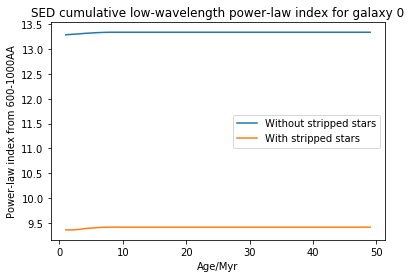

In [134]:
plt.plot(np.arange(49)+1, lowstdidx0, label='Without stripped stars')
plt.plot(np.arange(49)+1, lowsumidx0, label='With stripped stars')
plt.title("SED cumulative low-wavelength power-law index for galaxy 0")
plt.xlabel("Age/Myr")
plt.ylabel("Power-law index from 600-1000AA")
plt.legend()
#plt.xscale('log')
#plt.yscale('log')